# Project 1: Mining information from Text Data 
<hr>

This project will explore and analyze the information stored in a particular dataset. In this case the ACL Anthology dataset (https://aclanthology.org/). We will explore different techniques for obtainingn valuable information.

## Task 1: Finding Similar Items

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

 
 

<hr>

#### 1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

0. Import libraries

In [1]:
from urllib.request import urlopen
from io import BytesIO
from time import time

import gzip
import re
import binascii
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools

1. Load data and make some preprocessing

In [2]:
url  = 'https://aclanthology.org/anthology+abstracts.bib.gz'
filename = 'anthology+abstracts.bib'
minimum = 200

with gzip.open(BytesIO(urlopen(url).read()), 'rb') as fb:
    with open(filename, 'wb') as f:
        f.write(fb.read())

file = open(filename)
abstracts = []
with open(filename, 'r',errors='ignore') as f:
    # skip all lines until abstract
    for line in f:
      if 'abstract = "' in line:                                  # abstract found
        if len(re.findall('[a-zA-Z]', line)) > .2*len(line):      # ignore non latin
          if len(line) > minimum:                                 # ignore abstracts with less than minimum words (200)
            line = re.sub(' +', ' ', line)                        # remove double spaces
            line = re.sub(' abstract = ', '', line)               # remove "abstract ="
            line = re.sub('"|\n|,', '', line)                     # remove some other characters  
            line = line.lower()                                   # transform to lower letters 
            abstracts.append(line)

print('Number of abstracts:', len(abstracts))
print('Example:', abstracts[0])       

Number of abstracts: 30071
Example: offensive language detection (old) has received increasing attention due to its societal impact. recent work shows that bidirectional transformer based methods obtain impressive performance on old. however such methods usually rely on large-scale well-labeled old datasets for model training. to address the issue of data/label scarcity in old in this paper we propose a simple yet effective domain adaptation approach to train bidirectional transformers. our approach introduces domain adaptation (da) training procedures to albert such that it can effectively exploit auxiliary data from source domains to improve the old performance in a target domain. experimental results on benchmark datasets show that our approach albert (da) obtains the state-of-the-art performance in most cases. particularly our approach significantly benefits underrepresented and under-performing classes with a significant improvement over albert.


2. Randomly select 1000 abstracts

In [3]:
# initializing the value of n_abstracts
n_abstracts= 1000
  
# getting random n elements from the list
abstracts = random.sample(abstracts, n_abstracts)
print('Number of abstracts:', len(abstracts))

Number of abstracts: 1000


3. Define main functions

In [4]:
def get_shingles(a, k):
    L = len(a)
    shingles = set()                                  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = a[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) # hash the shingle to a 32-bit integer
        shingles.add(crc)    
    return shingles     

In [5]:
def jaccard_similarity_score(x, y):
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [6]:
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [7]:
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID):
    numItems = signatures.shape[1]
    signBands = np.array_split(signatures, bands, axis=0)
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (np.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        np.sort(cand)
                        candidates.add(tuple(cand))
    return candidates

In [8]:
def plot_results(title):
    plt.rcParams["figure.figsize"] = (15,6)

    plt.subplot(1,2,1)
    objects = ('S=0.1/K=3', 'S=0.1/K=5', 'S=0.1/K=10', 'S=0.2/K=3', 'S=0.2/K=5', 'S=0.2/K=10')
    y_pos = np.arange(len(objects))
    metric = times
    plt.barh(y_pos, metric, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title(title +' (time)')

    plt.subplot(1,2,2)
    y_pos = np.arange(len(objects))
    metric = similar_items
    plt.barh(y_pos, metric, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title(title + ' (items)')

    plt.show()

4. Jaccard Similarity: (CAUTION: This process takes long execution time!!)

In [9]:
similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

similar_items = []
times = []

for s in similarity_threshold:
    for k in k_shingles:

        candidates = []
        t = time()
        for pair in itertools.combinations(abstracts,2):
            js = jaccard_similarity_score(get_shingles(pair[0], k),get_shingles(pair[1], k))    
            if js > s:
                candidates.append(pair)
        t1 = time()-t
        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        similar_items.append(len(candidates))
        times.append(t1)
        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 492992
Took 395.0993957519531 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 5362
Took 411.29351925849915 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 1
Took 419.66449069976807 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 358837
Took 392.85950994491577 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 1
Took 412.25104784965515 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 1
Took 415.15744948387146 seconds



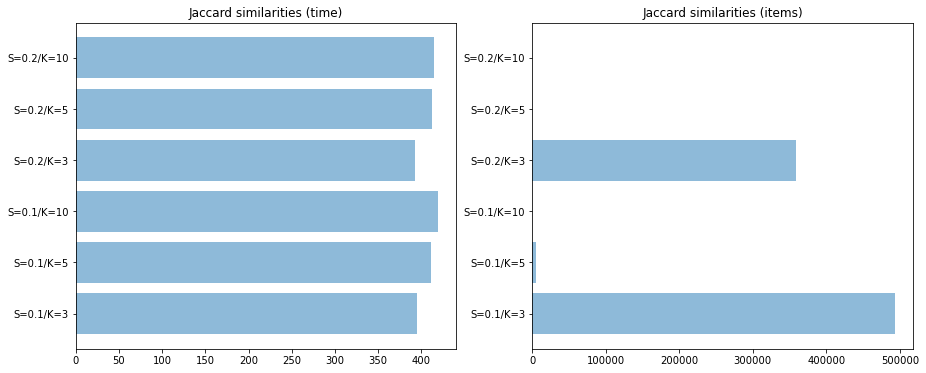

In [10]:
plot_results('Jaccard similarities')

5. MinHashing

In [15]:
# get candidate pairs using MinHashing
# set global parameters to process the whole dataset
bands = 5          # number of bands
rows = 10          # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

similar_items = []
times = []

for s in similarity_threshold:
    
    for k in k_shingles:
        
        signatures = []  # signatures for all files
        
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)
            
        Nfiles = len(signatures)
        
        t = time()
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                    candidates.append((i,j))
        t1 = time() - t

        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        
        similar_items.append(len(candidates))
        times.append(t1)        

        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 491611
Took 4.306140899658203 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 107658
Took 4.212770223617554 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 94
Took 4.1809914112091064 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 396401
Took 4.2830047607421875 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 1525
Took 4.246567726135254 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 1
Took 4.1715779304504395 seconds



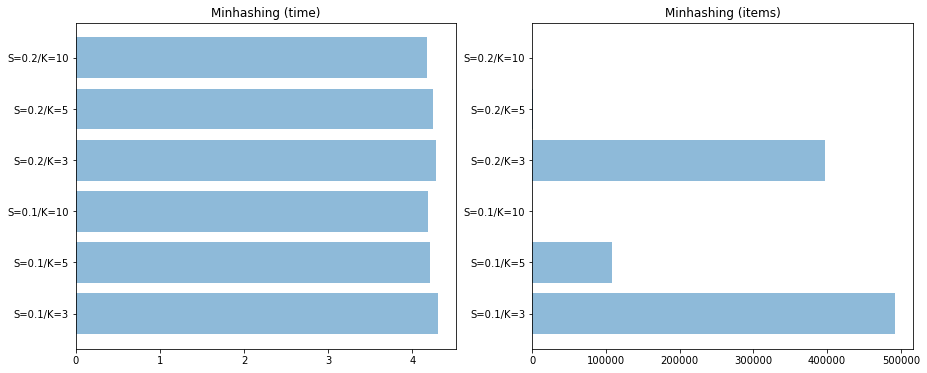

In [16]:
plot_results('Minhashing')

6. Locality Sensitive Hashing (LSH)

In [26]:
# Find candidates with LSH --> S=0.1
bands = 100        # number of bands
rows = 2           # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

k_shingles = [3, 5, 10]

similar_items = []
times = []

for k in k_shingles:
    signatures = []  # signatures for all files
    for a in abstracts:
        shingles = get_shingles(a, k)
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
        signatures.append(signature)

    # prepare data for LSH
    A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
    B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
    signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

    #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows (r) and the number of bands (b)
    Nfiles = signatures.shape[1]  # number of different files
    t = time()
    candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
    t1 = time() - t
     
    print('K_Shingles:', k)        
    print('Num of candidates found:', len(candidates))    
    print("Took {} seconds\n".format(t1))     
    similar_items.append(len(candidates))
    times.append(t1)        

K_Shingles: 3
Num of candidates found: 489635
Took 10.798424005508423 seconds

K_Shingles: 5
Num of candidates found: 171759
Took 1.2896521091461182 seconds

K_Shingles: 10
Num of candidates found: 1896
Took 0.3939981460571289 seconds



In [27]:
# Find candidates with LSH --> S=0.2
bands = 125
rows = 3
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

k_shingles = [3, 5, 10]

for k in k_shingles:
    signatures = []  # signatures for all files
    for a in abstracts:
        shingles = get_shingles(a, k)
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
        signatures.append(signature)

    # prepare data for LSH
    A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
    B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
    signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

    #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows (r) and the number of bands (b)
    Nfiles = signatures.shape[1]  # number of different files
    t = time()
    candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
    t1 = time() - t
     
    print('K_Shingles:', k)        
    print('Num of candidates found:', len(candidates))    
    print("Took {} seconds\n".format(t1))     
    similar_items.append(len(candidates))
    times.append(t1)   

K_Shingles: 3
Num of candidates found: 307665
Took 2.6600584983825684 seconds

K_Shingles: 5
Num of candidates found: 12355
Took 0.5629680156707764 seconds

K_Shingles: 10
Num of candidates found: 79
Took 0.45701169967651367 seconds



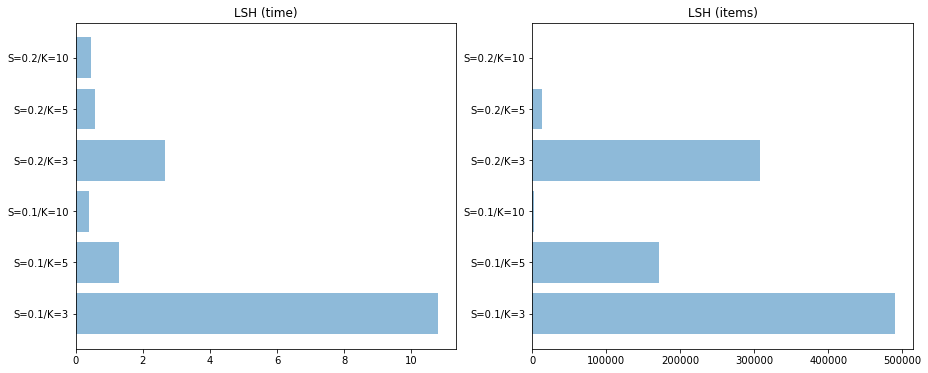

In [28]:
plot_results('LSH')

200 0.1
375 0.2


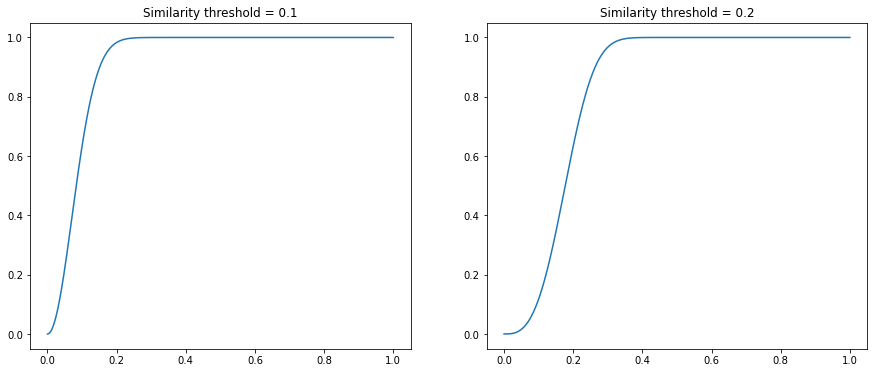

In [25]:
# Plot the selected number of bands and rows to obtain the desired threshold

# s = 0.1
b1 = 100
r1 = 2
print(b1*r1, (1.0/b1)**(1.0/r1))

# s = 0.2
b2 = 125
r2 = 3
print(b2*r2, (1.0/b2)**(1.0/r2))

t = np.linspace(0,1,1000)  # just lots of points between 0 and 1 for plotting
p1 = 1 - np.power((1 - np.power(t, r1)), b1)  # Formula: p = 1 - (1 - t^r)^b 
p2 = 1 - np.power((1 - np.power(t, r2)), b2)  # Formula: p = 1 - (1 - t^r)^b 

plt.rcParams["figure.figsize"] = (15,6)

plt.subplot(1,2,1)
plt.title('Similarity threshold = 0.1')
plt.plot(t,p1)
    
plt.subplot(1,2,2)
plt.title('Similarity threshold = 0.2')
plt.plot(t,p2)

plt.show()

7. Comments

<hr>

#### 2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

In [49]:
# s = 0.2
b2 = 60
r2 = 3
print(b2*r2, (1.0/b2)**(1.0/r2))

180 0.2554364774645177


<hr>

## Task 2: Mining information from Text Data 

Using the whole anthologies abstract dataset. Extract a list of the authors and editors per publication and create baskets and perform a search of similar items, for example:

- basket 1: Mostafazadeh Davani Aida,Kiela Douwe,Lambert Mathias,Vidgen, Bertie Prabhakaran Vinodkumar, Waseem, Zeerak
- basket 2: Singh Sumer, Li Sheng

1. Find the frequent pair of items (2-tuples) using the naïve, A-priori and PCY algorithms. For each of these compare the time of execution and results for supports s=10, 50, 100. Comment your results. 

2. For the PCY algorithm, create up to 5 compact hash tables. What is  the difference in results and time of execution for 1,2,3,4 and 5 tables? Comment your results.

3. Find the final list of k-frequent items (k-tuples) for k=3 and 4. Experiment a bit and describe the best value for the support in each case. *Warning*: You can use any of the three algorithms, but be careful, because the algorithm can take too long if you don't chose it properly (well, basically don't use the naïve approach ;)).

4. Using one of the results of the previous items, for one k (k=2 or 3) find the possible clusters using the 1-NN criteria. Comment your results.

> 1-NN means that if you have a tuple {A,B,C} and {C,E,F} then because they share one element {C}, then they belong to the same cluster  {A,B,C,E,F}.

<hr>

## Task 3: Graphs and Social Networks

Using the whole anthologies abstract dataset.

1. From the abstracts part, using two different similarity thresholds (e.g. 0.05, 0.1), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.

2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.